# Bias-correction

This notebook will cover a very useful and exciting topic in the context of climate data: bias correction! It will do so *lightly* - it is intended to provide some examples of what **can** be done, not necessarily what **should** be done! 

Bias-correction methods attempt to correct the systematic errors present in modeled data. For example, a model may overestimate the number of rainy days and underestimate the number of extreme rainfall events. While summaries of rainfall over long periods of time could still match in this case, it would obviously be ideal if this aspect of the rainfall pattern was correct, too! 

Here are some more resources to read about bias-correction:
* [Copernicus Climate Change Service](https://climate.copernicus.eu/sites/default/files/2021-01/infosheet7.pdf)
* [Statistical Downscaling and Bias-Adjustment tools in the `xclim` docs](https://xclim.readthedocs.io/en/stable/sdba.html)

We will be using the `xclim` library to perform the adjustments here. 

## Pixel-to-point bias

There is another type of "bias" that we will look into first, before we get to the systematic model bias which bias-correction efforts often seek to address: the bias inherent to our desire for gridded data at a particular point of interest. This is the error between a pixel's spatial aggregate value (usually an average) and the observed values for that same variable at that point. 

Take for example the following goal: we want ERA5-Land 2m air temperature data for Eagle, Alaska, for 1990-1999. We want this data for the typical reason one might want gridded data instead of just the coincident observational data: greater temporal coverage! The ERA5-Land data will have no gaps, while the observed data (spoiler alert) is missing large chunks for this time period.

So, we will get all of the available routine hourly observed data for 1990-1999, and all ERA5-Land data for 1990-1999 for the pixel which is intersected by Eagle. We will then bias-correct the ERA5-Land data to achieve a continuous timeseries of 2m air temperature data that we would expect to be closer to what the true values were than the original ERA5-Land data.

#### Download observed data

The [Automated Surface Observing Systems](https://www.weather.gov/asos/asostech) is responsible for the most comprehensive collection of observed meterological data in Alaska. There are multiple ways to access this data, but we will use the [Iowa Environmental Mesonet's archive](https://mesonet.agron.iastate.edu/request/download.phtml?network=AK_ASOS), which provides a nice API for getting data that has already been quality-controlled to some extent.

First, load the libraries we will need:

In [164]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pathlib import Path
from xclim import sdba
from xclim.core import units

from ardac_utils import unzip, cdsapi_timerange_params

Details on constructing this API call (the URL) can be found through the application in link above. For now, the reader only needs to know that we are requesting hourly observations of 2m air temperature (in Fahrenheit) from 1990-1999 for the observing station at the Eagle airport. We are using `pandas` directly to read this link into a `DataFrame`:

In [96]:
url = (
    "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=PAEG"
    "&data=tmpf&year1=1990&month1=1&day1=1&year2=1999&month2=12&day2=31&tz=Etc%2FUTC"
    "&format=onlycomma&latlon=no&elev=no&missing=empty&trace=T&direct=yes&report_type=3"
)
df = pd.read_csv(url, parse_dates=["valid"])
# set the "valid" variable as the index
df = df.rename(columns={"valid": "time"}).set_index("time").drop(columns="station")

Let's explore these observations a bit. Have a look at the time series as a whole:

<Axes: xlabel='time'>

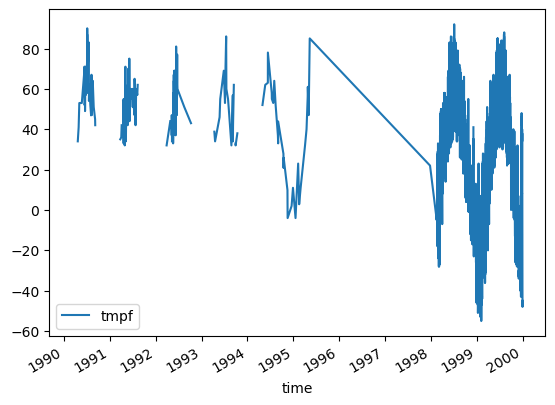

In [95]:
df.plot()

So, it looks like the data collection may only have been conducted for part of the summers during much of this time period, as there are practically no sub-30 degree observations until the late 1990's. It looks like continuous recording began about two months into 1998.

#### Download ERA5-Land data

Next, we need to download the ERA5-Land data. See the [era5_access.ipynb](./era5_access.ipynb) notebook for help on retrieving this data. 

Below is a code snippet which can be pasted into a script and run via `python <script>.py` to download all of the data. While it is not a ton of data, various factors can influence the speed at which the CDS API can package and return this data from the underlying dataset, and in testing, this data took about 4 hours to get here. 

Since we will be requesting hourly data for 1990-1999, we will be pulling 10 years * ~8760 hours = ~87600 records, which exceeds their current limit of 12000 records per request. To keep things simple, we will iterate over each year and request data for that year. 

Here is the script:

(not sure if this is the best way to share this script)
```python

import cdsapi
from pathlib import Path
from ardac_utils import unzip, cdsapi_timerange_params

# Eagle airport coordinates
lat = 64.7780833
lon = -141.1496111
ak_bbox = [lat, lon, lat, lon]

params = {
    "format": "netcdf.zip",
    "variable": "2m_temperature",
    "area": ak_bbox,
}

c = cdsapi.Client()

eagle_era5_dir = Path("eagle_era5land")
eagle_era5_dir.mkdir(exist_ok=True)
for year in range(1990, 2000):
    download_path = eagle_era5_dir.joinpath(f"era5land_eagle_{year}.netcdf.zip")
    time_params = cdsapi_timerange_params(
        start_time=f"{year}-01-01", end_time=f"{year}-12-31 23:00:00", freq="h"
    )
    params.update(time_params)
    c.retrieve("reanalysis-era5-land", params, download_path)

    unzip_path = eagle_era5_dir.joinpath(download_path.name.replace(".netcdf.zip", ".nc"))
    unzip(download_path, unzip_path)
```

Once that script completes, you should have a folder containing files named `era5land_eagle_<year>.nc` for all years in 1990-1999. We can now do some comparisons between the observed data and the ERA5-Land data. 

Open a connection to the data from the collection of yearly files using the `xarray.open_mfdataset` function:

In [111]:
eagle_era5_dir = Path("eagle_era5land")
# this function can open multiple files into a dataset at once
# it infers that it should join on the time dimension
ds = xr.open_mfdataset(eagle_era5_dir.glob("*.nc"))

The ERA5 2m air temperature data is in Kelvin, so we will want to convert to Fahrenheit. The `xclim` library we will use for the bias correction provides a function for doing so. Convert, and view the plot of the whole timeseries:

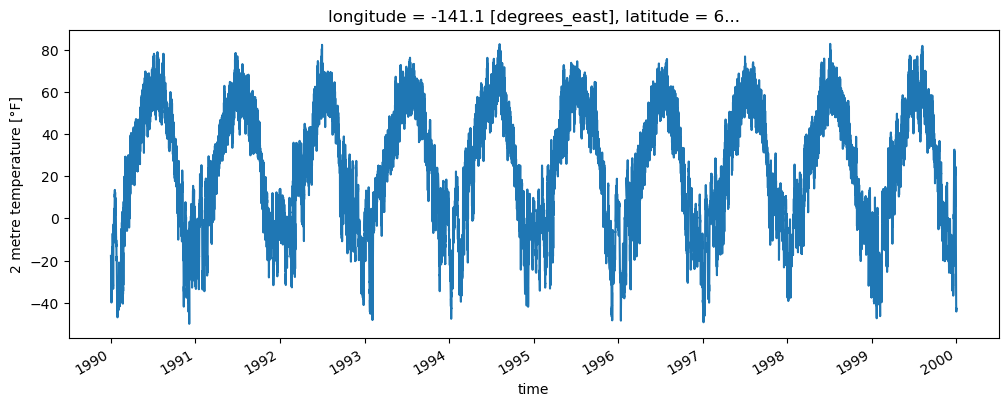

In [112]:
t2mF = units.convert_units_to(ds.t2m, "degF")
# load the data into memory so it's no longer a dask array
t2mF = t2mF.load()
t2mF.plot(figsize=(12, 4))

You can see that the ERA5 data is temporally complete.

Now let's plot both for a time period where the observational record is mostly complete, so we can have a closer inspection. How about a couple months in 1998, roughly coinciding with the beginning of the consistent observations happening at Eagle:

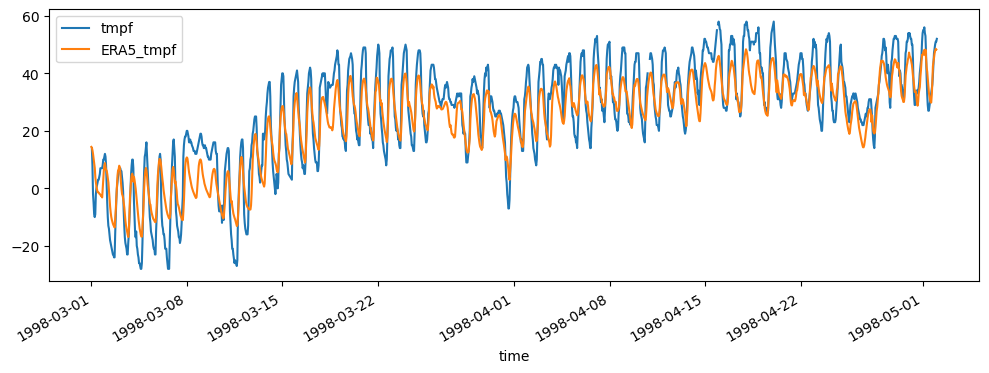

In [162]:
# first we are just pulling out that ERA5 data into a dataframe for a more consistent plotting
# set an example time slice
ex_slice = slice("1998-03-01", "1998-05-01")
era5_srs = t2mF.sel(
    time=ex_slice,
    latitude=t2mF.latitude.values[0],
    longitude=t2mF.longitude.values[0],
).to_pandas()
era5_srs.name = "ERA5_tmpf"
era5_df = pd.DataFrame(era5_srs)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df.loc[ex_slice].plot(ax=ax)
era5_df.plot(ax=ax)
plt.show()

This is a good example of grid cell "bias" - notice how the ERA5-Land temperature is generally accurate, following daily cycles, but the variation appears to be muted, in that observed minimums are generally lower, and observed maximums are generally larger. 

#### Adjust the data

We will now correct the bias of the ERA5-Land data, using the `xclim` library. 

First, make a `DataArray` object from the observed data:

In [143]:
ref = xr.DataArray(df.tmpf)
ref.attrs["units"] = "degree_Fahrenheit"

Subset that to the continuous portion of the reference period:

In [163]:
ref = ref.sel(time=slice("1998-03-01", "1999-12-31"))

Susbet the ERA5-Land data to the same time period:

In [149]:
hist = t2mF.sel(time=slice("1998-03-01", "1999-12-31"))

The code used here is largely borrowed from the [example notebook in the `xclim` docs](https://xclim.readthedocs.io/en/stable/notebooks/sdba.html). It is very useful and covers multiple methods for bias adjustment. We will show a simple example, and then a more complex example. 

First, the simple example, which uses only a quantile mapping algorithm with 15 quantiles and one group of values. We create the adjustment factors (`QM`) by "training" the observation-coincident subset of the ERA5-Land data (`hist`) onto the observations (`ref`), and then adjust:

In [166]:
QM = sdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time.month", kind="+"
)
scen = QM.adjust(t2mF, extrapolation="constant", interp="linear")

Now, plot the corrected ERA5-Land data along with the observed data, like we did above:

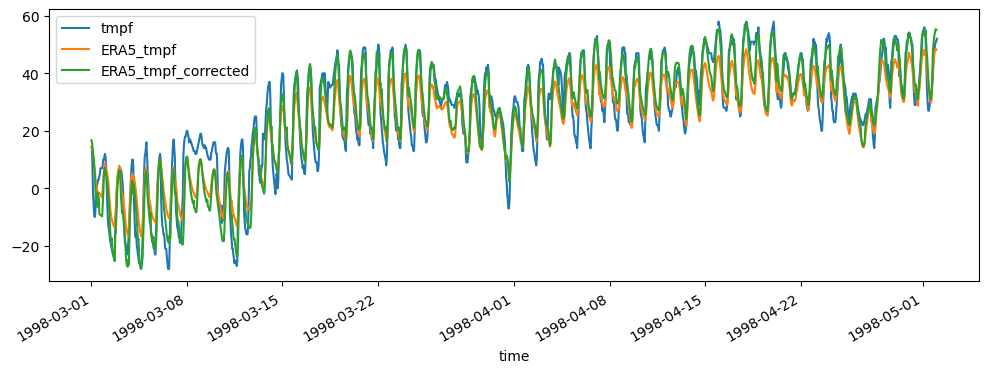

In [168]:
new_era5 = scen.sel(
    time=ex_slice,
    latitude=scen.latitude.values[0],
    longitude=scen.longitude.values[0],
).to_pandas()
new_era5.name = "ERA5_tmpf_corrected"
new_era5 = pd.DataFrame(new_era5)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df.loc[ex_slice].plot(ax=ax)
era5_df.plot(ax=ax)
new_era5.plot(ax=ax)
plt.show()

You can see there is generally some improvement - the corrected ERA5-Land data generally matches the observed data better, particularly in the daily maximums. However, there is still some room for improvement. 

Next, we will demonstrate a method that uses scaling and detrending to hopefully improve this adjustment (taken from [this section](https://xclim.readthedocs.io/en/stable/notebooks/sdba.html#Second-example:-tas-and-detrending) of the example notebook linked above):

In [169]:
doy_win31 = sdba.Grouper("time.dayofyear", window=15)
Sca = sdba.Scaling.train(ref, hist, group=doy_win31, kind="+")
sim_scl = Sca.adjust(t2mF)

detrender = sdba.detrending.PolyDetrend(degree=1, group="time.dayofyear", kind="+")
sim_fit = detrender.fit(sim_scl)
sim_detrended = sim_fit.detrend(sim_scl)

ref_n, _ = sdba.processing.normalize(ref, group=doy_win31, kind="+")
hist_n, _ = sdba.processing.normalize(hist, group=doy_win31, kind="+")

QM = sdba.EmpiricalQuantileMapping.train(
    ref_n, hist_n, nquantiles=15, group="time.month", kind="+"
)
scen_detrended = QM.adjust(sim_detrended, extrapolation="constant", interp="nearest")
scen = sim_fit.retrend(scen_detrended)

/Users/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/Users/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/adjustment.py:118: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/Users/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(va

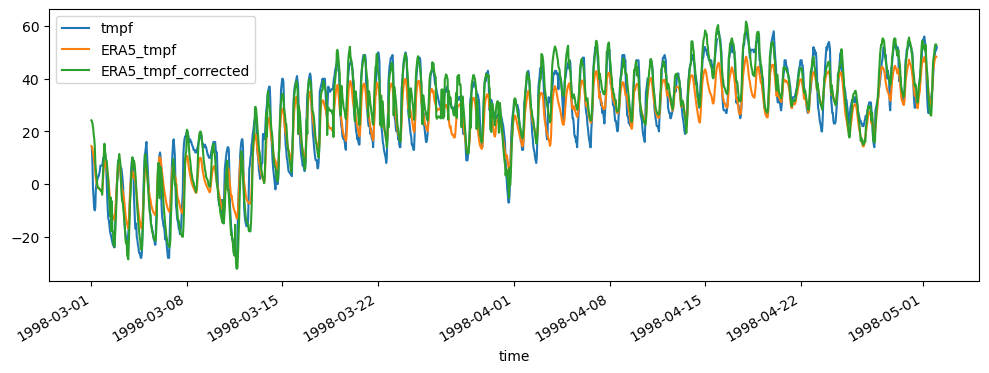

In [170]:
new_era5 = scen.sel(
    time=ex_slice,
    latitude=scen.latitude.values[0],
    longitude=scen.longitude.values[0],
).to_pandas()
new_era5.name = "ERA5_tmpf_corrected"
new_era5 = pd.DataFrame(new_era5)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df.loc[ex_slice].plot(ax=ax)
era5_df.plot(ax=ax)
new_era5.plot(ax=ax)
plt.show()

How did it do for time periods that were not part of the training data? Let's look at say, June-August of 1990, where there were some (albiet comparatively few) observations:

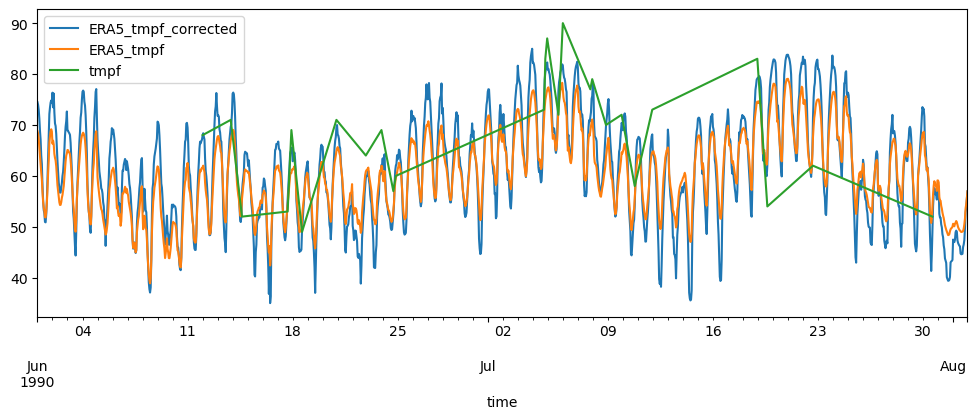

In [181]:
ex_slice2 = slice("1990-06-01", "1990-08-01")
new_era5 = scen.sel(
    time=ex_slice2,
    latitude=scen.latitude.values[0],
    longitude=scen.longitude.values[0],
).to_pandas()
new_era5.name = "ERA5_tmpf_corrected"
new_era5 = pd.DataFrame(new_era5)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

new_era5.plot(ax=ax)
era5_df[ex_slice2].plot(ax=ax)

df.loc[ex_slice2].plot(ax=ax)

plt.show()

We can view the entire ERA5-Land time series now, before and after correction:

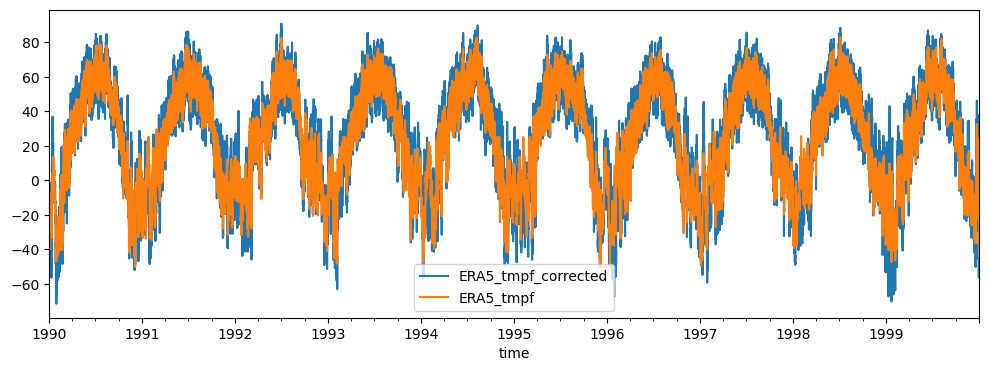

In [171]:
# first we are just pulling out that ERA5 data into a dataframe (so that the label will show)
new_era5 = scen.sel(
    latitude=scen.latitude.values[0],
    longitude=scen.longitude.values[0],
).to_pandas()
new_era5.name = "ERA5_tmpf_corrected"
new_era5 = pd.DataFrame(new_era5)
era5_srs = t2mF.sel(
    latitude=t2mF.latitude.values[0],
    longitude=t2mF.longitude.values[0],
).to_pandas()
era5_srs.name = "ERA5_tmpf"
era5_df = pd.DataFrame(era5_srs)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
new_era5.plot(ax=ax)
era5_df.plot(ax=ax)
plt.show()

It is clear that the corrected version has higher highs, and lower lows!